In [2]:
import pandas as pd
import numpy as np

# Load your datasets 
car_panel = pd.read_csv(r"D:/LSE Career Accelerator/Employer project/Adrian's financial metrics data/event_study_abnormal_returns_panel_10_20_v2.csv")
fund = pd.read_csv(r"D:/LSE Career Accelerator/Employer project/Adrian's financial metrics data/full_event_regimes.csv")

In [3]:
# Ensure event_id is consistent
car_panel['event_id'] = car_panel['event_id'].astype(str)
fund['event_id'] = fund['event_id'].astype(str)


In [24]:
def compute_car_windows(event_df):
    df = event_df.sort_values("event_day").copy()

    # Only keep post-event days (event_day >= 0)
    post = df[df["event_day"] >= 0].copy()

    # Compute CAR and CAR_abs
    post["CAR"] = post["abnormal_return"].cumsum()
    post["CAR_abs"] = post["abnormal_return"].abs().cumsum()

    def get_closest(day):
        # first event_day >= target day
        row = post.loc[post["event_day"] >= day]
        return row["CAR"].iloc[0] if len(row) else np.nan

    def get_closest_abs(day):
        row = post.loc[post["event_day"] >= day]
        return row["CAR_abs"].iloc[0] if len(row) else np.nan

    return pd.Series({
        "CAR1": get_closest(1),
        "CAR3": get_closest(3),
        "CAR5": get_closest(5),
        "CAR20": get_closest(20),
        "CAR_abs_5": get_closest_abs(5),
        "CAR_abs_20": get_closest_abs(20)
    })

In [25]:
car_windows = (
    car_panel
    .groupby("event_id", group_keys=False)
    .apply(compute_car_windows)
    .reset_index()
)

C:\Users\User\AppData\Local\Temp\ipykernel_6296\197530922.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(compute_car_windows)


In [26]:
car_windows.head()

event_id      CAR1      CAR3      CAR5     CAR20  CAR_abs_5  \
0  AAPL_2005-07-13  0.056254  0.075860  0.075860  0.048157   0.078529   
1  AAPL_2005-10-11  0.018054  0.085950  0.069648  0.094402   0.169588   
2  AAPL_2006-01-18 -0.079386 -0.070483 -0.070483 -0.254186   0.096852   
3  AAPL_2006-04-19  0.017641  0.007382  0.007382  0.084366   0.072345   
4  AAPL_2006-07-19  0.145726  0.145525  0.145525  0.219412   0.197723   

   CAR_abs_20  
0    0.171598  
1    0.395868  
2    0.386239  
3    0.200513  
4    0.363892

In [27]:
car_windows = (
    car_panel
    .groupby("event_id", group_keys=False)
    .apply(compute_car_windows)
    .reset_index()
)

print(car_windows.head())


          event_id      CAR1      CAR3      CAR5     CAR20  CAR_abs_5  \
0  AAPL_2005-07-13  0.056254  0.075860  0.075860  0.048157   0.078529   
1  AAPL_2005-10-11  0.018054  0.085950  0.069648  0.094402   0.169588   
2  AAPL_2006-01-18 -0.079386 -0.070483 -0.070483 -0.254186   0.096852   
3  AAPL_2006-04-19  0.017641  0.007382  0.007382  0.084366   0.072345   
4  AAPL_2006-07-19  0.145726  0.145525  0.145525  0.219412   0.197723   

   CAR_abs_20  
0    0.171598  
1    0.395868  
2    0.386239  
3    0.200513  
4    0.363892  


C:\Users\User\AppData\Local\Temp\ipykernel_6296\2747742490.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(compute_car_windows)


In [55]:
car_panel = pd.read_csv(r"D:/LSE Career Accelerator/Employer project/Adrian's financial metrics data/event_study_abnormal_returns_panel_10_20_v2.csv")
car_panel['event_id'] = car_panel['event_id'].astype(str)
car_panel['date'] = pd.to_datetime(car_panel['date'])

In [56]:
announce_dates = (
    car_panel[car_panel["event_day"] == 0]
    .loc[:, ["event_id", "ticker", "date"]]
    .rename(columns={"date": "announcement_date"})
)

In [57]:
car_panel = car_panel.merge(
    announce_dates[["event_id", "announcement_date"]],
    on="event_id",
    how="left"
)

In [58]:
car_panel["event_id_corrected"] = (
    car_panel["ticker"] + "_" + car_panel["announcement_date"].dt.strftime("%Y-%m-%d")
)

In [59]:
car_windows = (
    car_panel
    .groupby("event_id_corrected", group_keys=False)
    .apply(compute_car_windows)
    .reset_index()
    .rename(columns={"event_id_corrected": "event_id"})
)

C:\Users\User\AppData\Local\Temp\ipykernel_6296\3689316172.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(compute_car_windows)


In [60]:
merged = fund.merge(car_windows, on="event_id", how="left")

In [61]:
merged[["event_id", "reportedDate", "CAR1", "CAR20"]].head()

event_id reportedDate      CAR1     CAR20
0  AAPL_2005-10-11   2005-10-11  0.018054  0.094402
1  AAPL_2006-01-18   2006-01-18 -0.079386 -0.254186
2  AAPL_2006-04-19   2006-04-19  0.017641  0.084366
3  AAPL_2006-07-19   2006-07-19  0.145726  0.219412
4  AAPL_2006-10-18   2006-10-18  0.062397  0.049025

In [62]:
# Compute Reaction Speed + Drift Persistence
final = merged.copy()

final["speed_day1"] = final["CAR1"] / final["CAR20"]
final["speed_day3"] = final["CAR3"] / final["CAR20"]
final["drift_persistence"] = final["CAR20"] / final["CAR5"]

In [63]:
# Regime‑Level Summary Tables
def regime_summary(df, regime_col):
    return df.groupby(regime_col)[
        ["CAR20", "CAR5", "speed_day1", "speed_day3", "drift_persistence"]
    ].mean()

eps_summary = regime_summary(final, "eps_surprise_regime")
profit_summary = regime_summary(final, "profitability_regime")
margin_summary = regime_summary(final, "margin_trend_regime")
growth_summary = regime_summary(final, "revenue_growth_regime")
strength_summary = regime_summary(final, "financial_strength_regime")

In [64]:
# Drift‑Path Curves (CAR path 0–20)
def compute_car_path(event_df):
    df = event_df.sort_values("event_day").copy()
    post = df[df["event_day"] >= 0].copy()
    post["CAR"] = post["abnormal_return"].cumsum()
    return post[["event_day", "CAR"]]

car_paths = (
    car_panel
    .groupby("event_id_corrected", group_keys=True)
    .apply(compute_car_path)
    .reset_index()
)


C:\Users\User\AppData\Local\Temp\ipykernel_6296\536275617.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(compute_car_path)


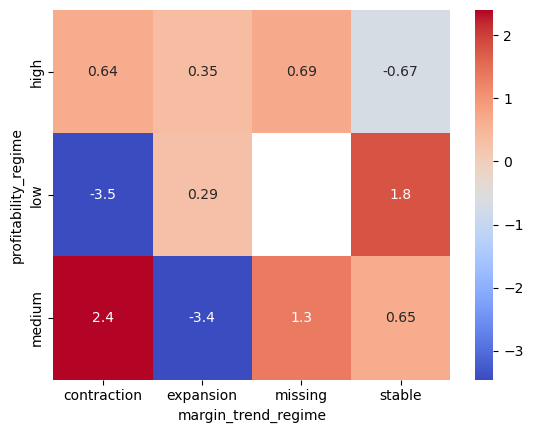

In [65]:
# Reaction‑Speed Heatmaps
import seaborn as sns
import matplotlib.pyplot as plt

pivot = final.pivot_table(
    values="speed_day1",
    index="profitability_regime",
    columns="margin_trend_regime"
)

sns.heatmap(pivot, annot=True, cmap="coolwarm")
plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_6296\308138529.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
C:\Users\User\AppData\Local\Temp\ipykernel_6296\308138529.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


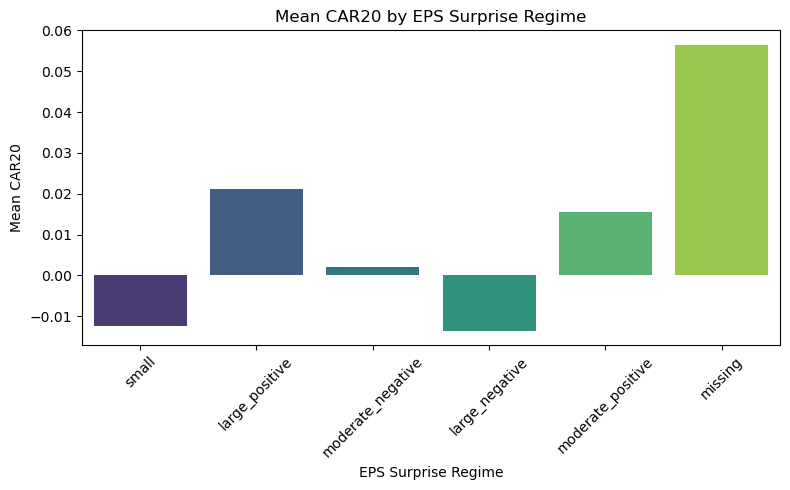

In [66]:
# Mean CAR20 by EPS Surprise Regime (Bar Chart)
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
sns.barplot(
    data=final,
    x="eps_surprise_regime",
    y="CAR20",
    estimator="mean",
    ci=None,
    palette="viridis"
)
plt.title("Mean CAR20 by EPS Surprise Regime")
plt.ylabel("Mean CAR20")
plt.xlabel("EPS Surprise Regime")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


C:\Users\User\AppData\Local\Temp\ipykernel_6296\1473029149.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
C:\Users\User\AppData\Local\Temp\ipykernel_6296\1473029149.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


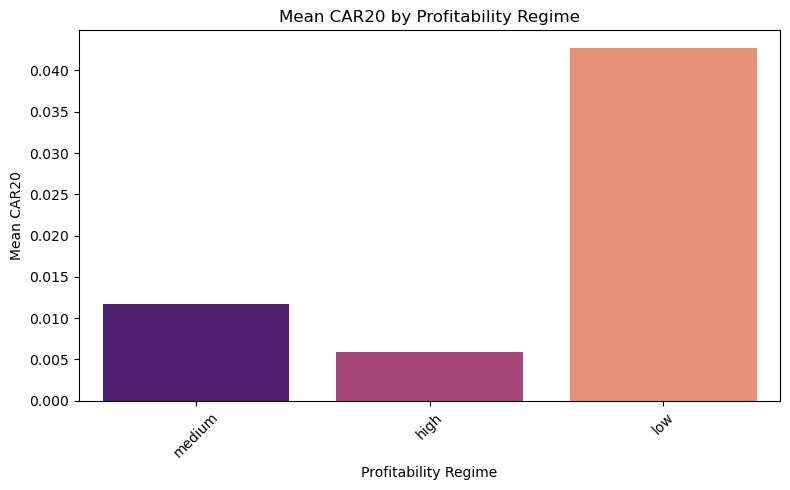

In [67]:
# Mean CAR20 by Profitability Regime
plt.figure(figsize=(8,5))
sns.barplot(
    data=final,
    x="profitability_regime",
    y="CAR20",
    estimator="mean",
    ci=None,
    palette="magma"
)
plt.title("Mean CAR20 by Profitability Regime")
plt.ylabel("Mean CAR20")
plt.xlabel("Profitability Regime")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_6296\3900877112.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
C:\Users\User\AppData\Local\Temp\ipykernel_6296\3900877112.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


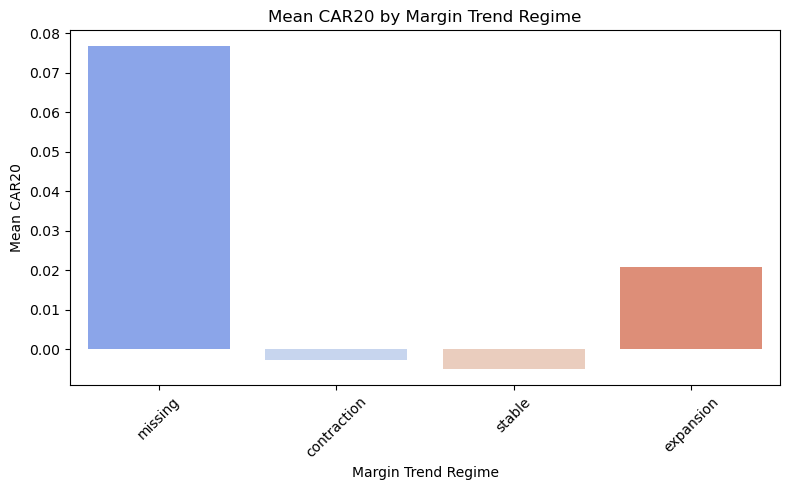

In [68]:
# Mean CAR20 by Margin Trend Regime
plt.figure(figsize=(8,5))
sns.barplot(
    data=final,
    x="margin_trend_regime",
    y="CAR20",
    estimator="mean",
    ci=None,
    palette="coolwarm"
)
plt.title("Mean CAR20 by Margin Trend Regime")
plt.ylabel("Mean CAR20")
plt.xlabel("Margin Trend Regime")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


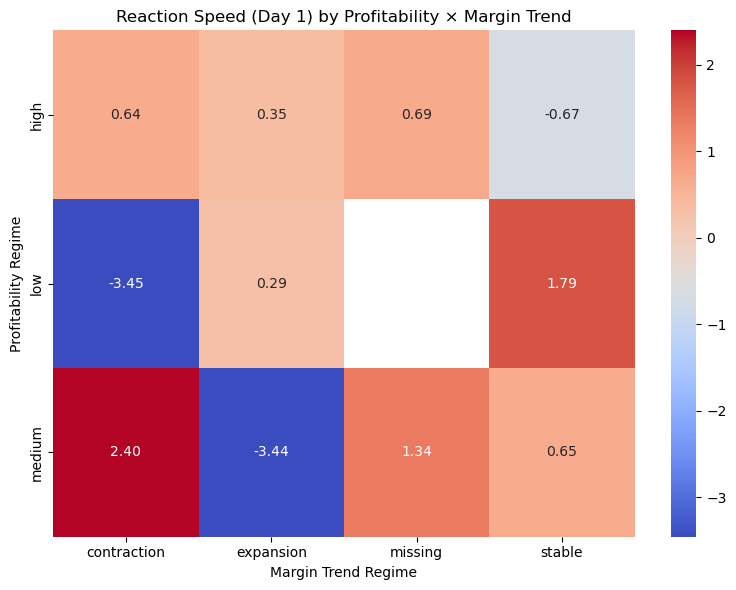

In [69]:
# Reaction‑Speed Heatmap (speed_day1)
pivot = final.pivot_table(
    values="speed_day1",
    index="profitability_regime",
    columns="margin_trend_regime",
    aggfunc="mean"
)

plt.figure(figsize=(8,6))
sns.heatmap(pivot, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Reaction Speed (Day 1) by Profitability × Margin Trend")
plt.ylabel("Profitability Regime")
plt.xlabel("Margin Trend Regime")
plt.tight_layout()
plt.show()


C:\Users\User\AppData\Local\Temp\ipykernel_6296\3004072475.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
C:\Users\User\AppData\Local\Temp\ipykernel_6296\3004072475.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


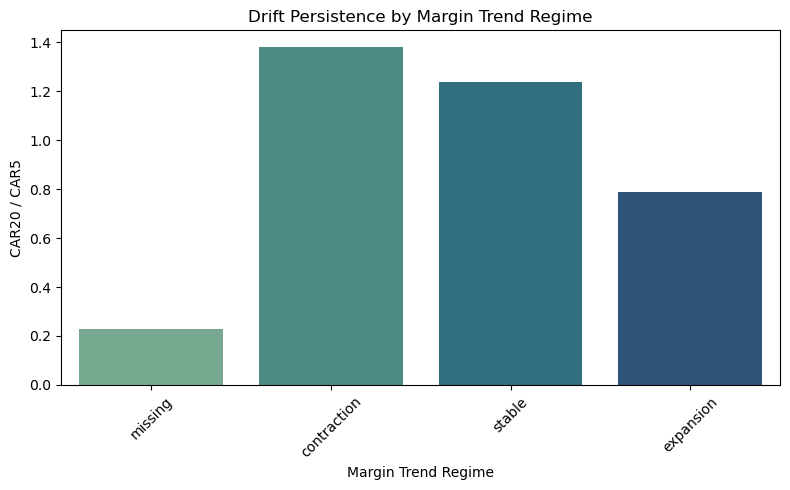

In [70]:
# Drift‑Persistence Bar Chart
plt.figure(figsize=(8,5))
sns.barplot(
    data=final,
    x="margin_trend_regime",
    y="drift_persistence",
    estimator="mean",
    ci=None,
    palette="crest"
)
plt.title("Drift Persistence by Margin Trend Regime")
plt.ylabel("CAR20 / CAR5")
plt.xlabel("Margin Trend Regime")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


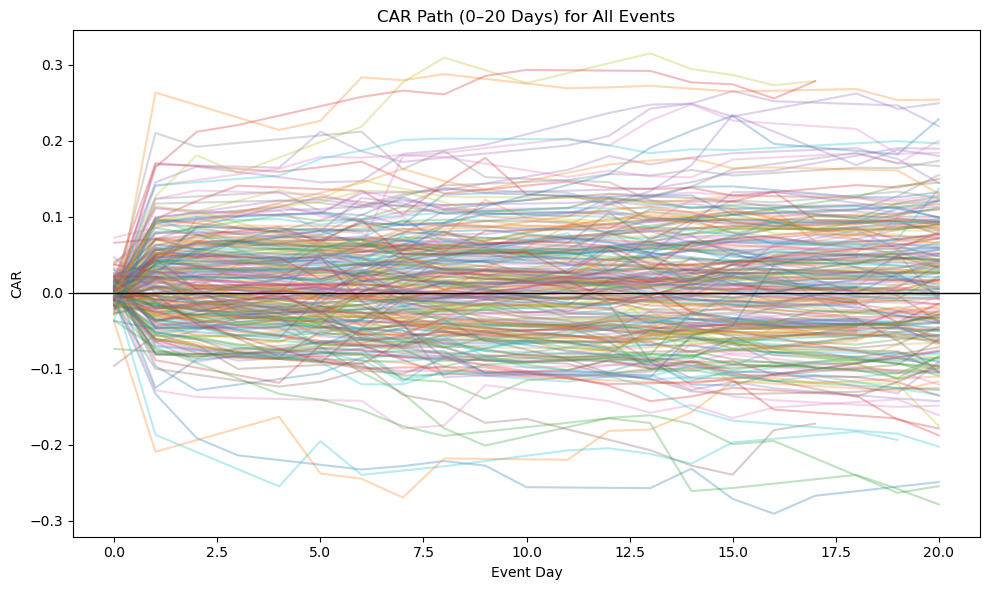

In [71]:
# Drift‑Path Curves (CAR path 0–20)
plt.figure(figsize=(10,6))

for eid, grp in car_paths.groupby("event_id_corrected"):
    plt.plot(grp["event_day"], grp["CAR"], alpha=0.3)

plt.title("CAR Path (0–20 Days) for All Events")
plt.xlabel("Event Day")
plt.ylabel("CAR")
plt.axhline(0, color="black", linewidth=1)
plt.tight_layout()
plt.show()

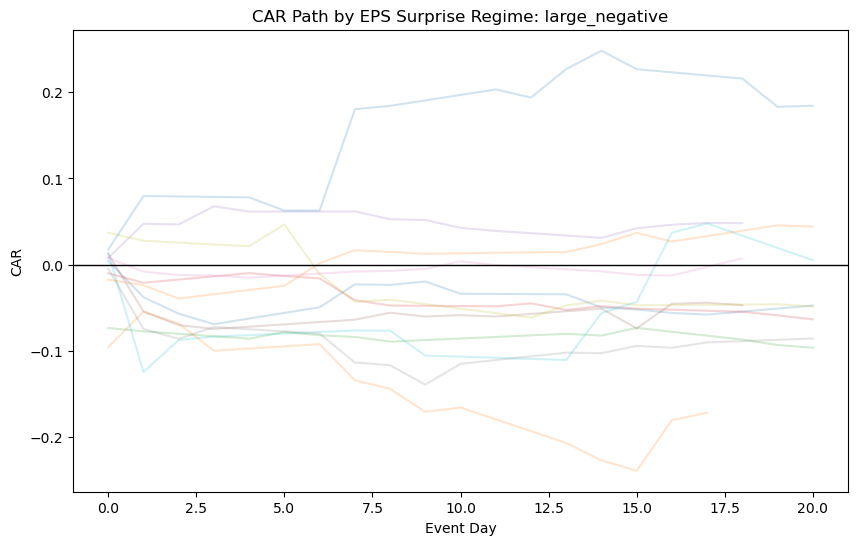

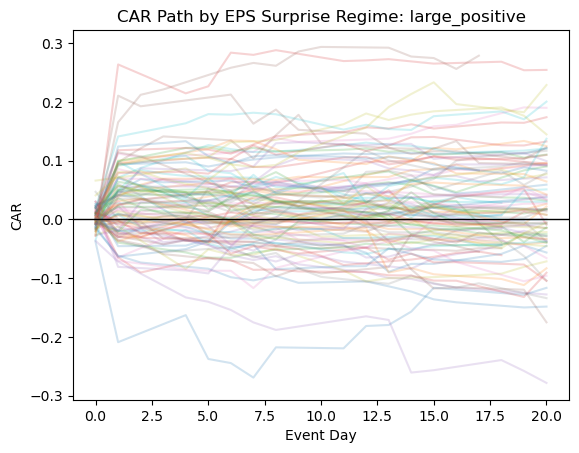

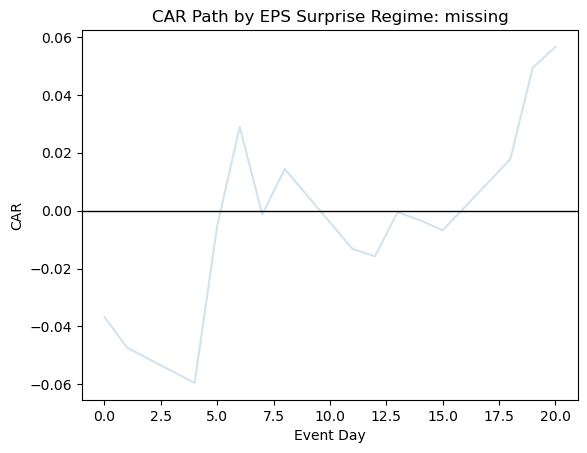

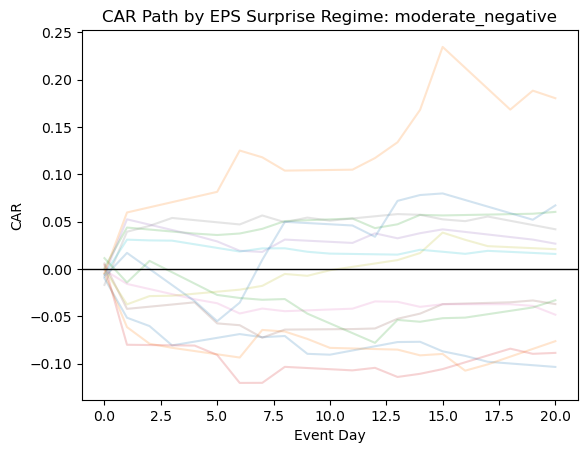

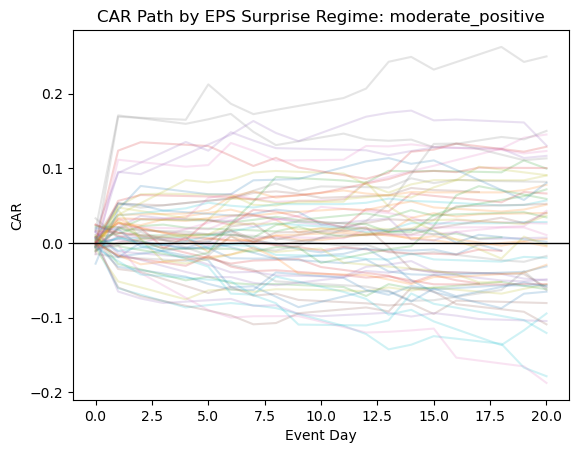

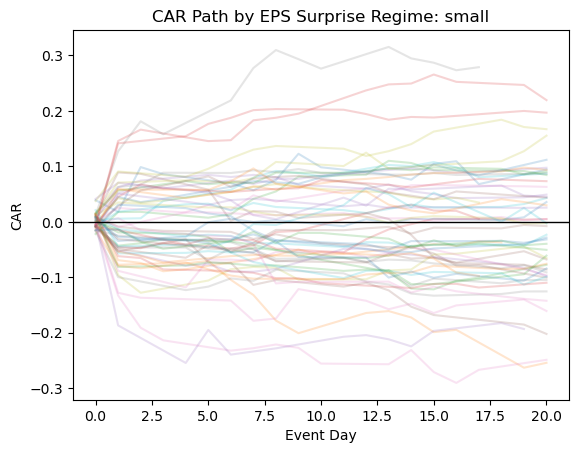

In [72]:
# Drift‑Path Curves by Regime
plt.figure(figsize=(10,6))

for regime, events in final.groupby("eps_surprise_regime")["event_id"]:
    for eid in events:
        grp = car_paths[car_paths["event_id_corrected"] == eid]
        plt.plot(grp["event_day"], grp["CAR"], alpha=0.2)

    plt.title(f"CAR Path by EPS Surprise Regime: {regime}")
    plt.xlabel("Event Day")
    plt.ylabel("CAR")
    plt.axhline(0, color="black", linewidth=1)
    plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_6296\4175136924.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
C:\Users\User\AppData\Local\Temp\ipykernel_6296\4175136924.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


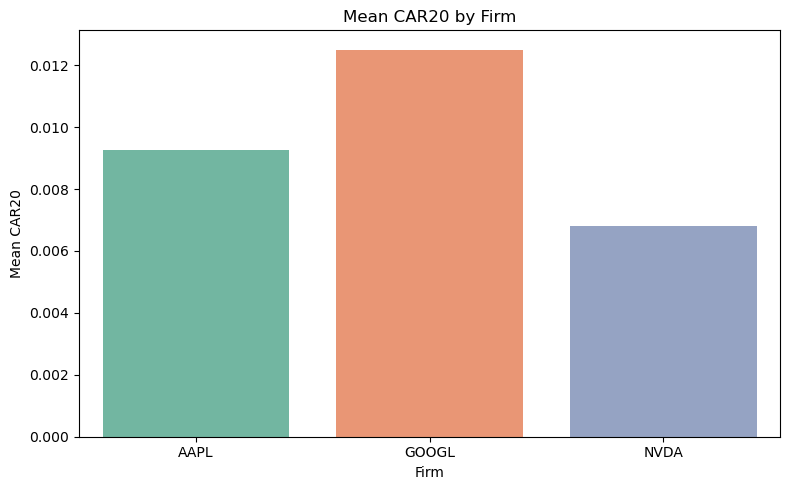

In [73]:
# Firm‑Level Drift Comparison (AAPL vs GOOGL vs NVDA)
plt.figure(figsize=(8,5))
sns.barplot(
    data=final,
    x="ticker",
    y="CAR20",
    estimator="mean",
    ci=None,
    palette="Set2"
)
plt.title("Mean CAR20 by Firm")
plt.ylabel("Mean CAR20")
plt.xlabel("Firm")
plt.tight_layout()
plt.show()

In [74]:
df_2022_2025 = df[(df['event_date'] >= '2022-01-01') & (df['event_date'] <= '2025-12-31')]

NameError: name 'df' is not defined

In [75]:
# Filter to 2022–2025 window
df_sub = df[(df['event_date'] >= '2022-01-01') & 
            (df['event_date'] <= '2025-12-31')].copy()

NameError: name 'df' is not defined

In [76]:
merged[["event_id", "reportedDate", "CAR1", "CAR20"]].head()

event_id reportedDate      CAR1     CAR20
0  AAPL_2005-10-11   2005-10-11  0.018054  0.094402
1  AAPL_2006-01-18   2006-01-18 -0.079386 -0.254186
2  AAPL_2006-04-19   2006-04-19  0.017641  0.084366
3  AAPL_2006-07-19   2006-07-19  0.145726  0.219412
4  AAPL_2006-10-18   2006-10-18  0.062397  0.049025

In [77]:
df_sub = merged[
    (merged['reportedDate'] >= '2022-01-01') &
    (merged['reportedDate'] <= '2025-12-31')
].copy()

In [78]:
df_sub['reportedDate'].min(), df_sub['reportedDate'].max(), df_sub.shape

(Timestamp('2022-01-27 00:00:00'), Timestamp('2025-11-19 00:00:00'), (48, 31))

In [80]:
merged[['event_id','firm','reportedDate']].head()

KeyError: "['firm'] not in index"

In [81]:
merged.columns.tolist()

['fiscalDateEnding',
 'reportedDate',
 'reportedEPS',
 'estimatedEPS',
 'surprise',
 'surprisePercentage',
 'reportTime',
 'symbol',
 'totalRevenue',
 'grossProfit',
 'operatingIncome',
 'netIncome',
 'grossMargin',
 'operatingMargin',
 'netMargin',
 'event_id',
 'ticker',
 'revenue_growth',
 'margin_trend',
 'profitability',
 'revenue_growth_regime',
 'eps_surprise_regime',
 'profitability_regime',
 'margin_trend_regime',
 'financial_strength_regime',
 'CAR1',
 'CAR3',
 'CAR5',
 'CAR20',
 'CAR_abs_5',
 'CAR_abs_20']

In [94]:
merged['reportedDate'] = pd.to_datetime(merged['reportedDate'])

df_sub = merged[
    (merged['reportedDate'] >= '2022-01-01') &
    (merged['reportedDate'] <= '2025-12-31')
].copy()

In [95]:
# Compute Reaction Speed + Drift Persistence
df_sub['reaction_speed'] = df_sub['CAR1'] / df_sub['CAR20']
df_sub['drift_persistence'] = df_sub['CAR20'] / df_sub['CAR5']

In [99]:
# Bucket reaction speed:
df_sub['reaction_speed_regime'] = pd.qcut(
    df_sub['reaction_speed'], 3, labels=['slow','medium','fast']
)


In [96]:
# Build the Firm × Regime Drift Tables
# Profitability × Firm
profit_firm = df_sub.groupby(['ticker','profitability_regime'])['CAR20'].mean().reset_index()
print(profit_firm)

  ticker profitability_regime     CAR20
0   AAPL                 high  0.004636
1  GOOGL                 high  0.001906
2  GOOGL               medium -0.025112
3   NVDA                 high -0.008525
4   NVDA                  low -0.142359
5   NVDA               medium  0.081621


In [97]:
# EPS surprise x firm
eps_firm = df_sub.groupby(['ticker','eps_surprise_regime'])['CAR20'].mean().reset_index()
print(eps_firm)


   ticker eps_surprise_regime     CAR20
0    AAPL      large_positive  0.016451
1    AAPL   moderate_negative  0.060348
2    AAPL   moderate_positive  0.007632
3    AAPL               small -0.014263
4   GOOGL      large_negative -0.067154
5   GOOGL      large_positive  0.024060
6   GOOGL   moderate_negative  0.018445
7   GOOGL   moderate_positive  0.026813
8   GOOGL               small -0.080221
9    NVDA      large_negative  0.044261
10   NVDA      large_positive  0.030314
11   NVDA   moderate_positive -0.002296
12   NVDA               small -0.142359


In [100]:
# Reaction Speed × Firm
speed_firm = df_sub.groupby(['ticker','reaction_speed_regime'])['CAR20'].mean().reset_index()
print(speed_firm)

  ticker reaction_speed_regime     CAR20
0   AAPL                  slow  0.002744
1   AAPL                medium -0.007122
2   AAPL                  fast  0.016690
3  GOOGL                  slow -0.012938
4  GOOGL                medium -0.001927
5  GOOGL                  fast  0.000848
6   NVDA                  slow -0.063047
7   NVDA                medium -0.020768
8   NVDA                  fast  0.104634


C:\Users\User\AppData\Local\Temp\ipykernel_6296\3498232214.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  speed_firm = df_sub.groupby(['ticker','reaction_speed_regime'])['CAR20'].mean().reset_index()


In [101]:
# Firm level CAR 20
firm_car20 = df_sub.groupby('ticker')['CAR20'].mean().reset_index()
print(firm_car20)

  ticker     CAR20
0   AAPL  0.004636
1  GOOGL -0.003883
2   NVDA  0.000013


In [105]:
car_panel.columns.tolist()

['event_id',
 'ticker',
 'date',
 'event_day',
 'abnormal_return',
 'announcement_date',
 'event_id_corrected']

In [111]:
panel.columns.tolist()

['event_id_x',
 'ticker_x',
 'date',
 'event_day',
 'abnormal_return',
 'announcement_date',
 'event_id_corrected',
 'event_id_y',
 'ticker_y',
 'reportedDate',
 'eps_surprise_regime',
 'CAR']

In [112]:
panel = panel.rename(columns={'ticker_y': 'ticker'})
panel = panel.drop(columns=['ticker_x'], errors='ignore')

In [113]:
panel = panel.rename(columns={'event_id_corrected': 'event_id'})
panel = panel.drop(columns=['event_id_x', 'event_id_y'], errors='ignore')

In [116]:
# Merge panel with regimes
panel = car_panel.merge(
    fund[['event_id','ticker','reportedDate','eps_surprise_regime']],
    left_on='event_id_corrected',
    right_on='event_id',
    how='left'
)

# Fix column names
panel = panel.rename(columns={
    'ticker_y': 'ticker',
    'event_id_corrected': 'event_id'
})
panel = panel.drop(columns=['ticker_x', 'event_id_x', 'event_id_y'], errors='ignore')

# Compute daily CAR
panel['CAR'] = panel.groupby('event_id')['abnormal_return'].cumsum()

# Filter to 2022–2025
panel['reportedDate'] = pd.to_datetime(panel['reportedDate'])
panel_sub = panel[
    (panel['reportedDate'] >= '2022-01-01') &
    (panel['reportedDate'] <= '2025-12-31')
].copy()

# Plot function
def plot_car_paths(df, ticker, regime):
    subset = df[(df['ticker']==ticker) & (df['eps_surprise_regime']==regime)]
    plt.figure(figsize=(10,6))

for event_id, grp in subset.groupby('event_id'):
        plt.plot(grp['event_day'], grp['CAR'], alpha=0.4)
    plt.axhline(0, color='black', linewidth=1)
    plt.title(f'CAR Path for {ticker} — {regime} (2022–2025)')
    plt.xlabel('Event Day')
    plt.ylabel('CAR')
    plt.show()

IndentationError: unindent does not match any outer indentation level (<string>, line 33)

In [117]:
# Merge panel with regimes
panel = car_panel.merge(
    fund[['event_id','ticker','reportedDate','eps_surprise_regime']],
    left_on='event_id_corrected',
    right_on='event_id',
    how='left'
)

# Fix column names
panel = panel.rename(columns={
    'ticker_y': 'ticker',
    'event_id_corrected': 'event_id'
})
panel = panel.drop(columns=['ticker_x', 'event_id_x', 'event_id_y'], errors='ignore')

# Compute daily CAR
panel['CAR'] = panel.groupby('event_id')['abnormal_return'].cumsum()

# Filter to 2022–2025
panel['reportedDate'] = pd.to_datetime(panel['reportedDate'])
panel_sub = panel[
    (panel['reportedDate'] >= '2022-01-01') &
    (panel['reportedDate'] <= '2025-12-31')
].copy()

# Plot function
def plot_car_paths(df, ticker, regime):
    subset = df[(df['ticker']==ticker) & (df['eps_surprise_regime']==regime)]
    plt.figure(figsize=(10,6))
    for event_id, grp in subset.groupby('event_id'):
        plt.plot(grp['event_day'], grp['CAR'], alpha=0.4)
    plt.axhline(0, color='black', linewidth=1)
    plt.title(f'CAR Path for {ticker} — {regime} (2022–2025)')
    plt.xlabel('Event Day')
    plt.ylabel('CAR')
    plt.show()

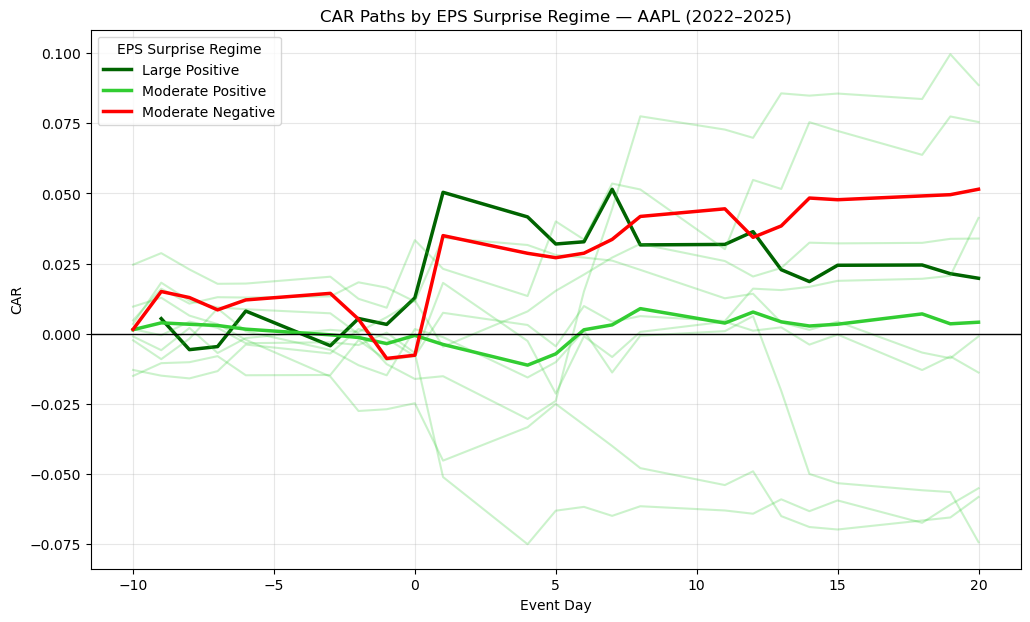

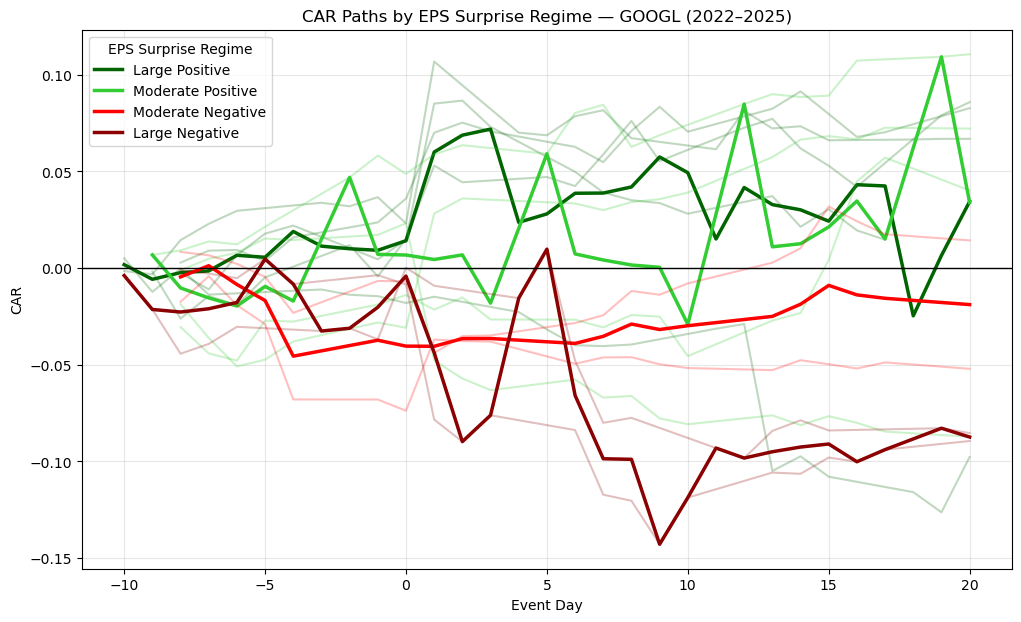

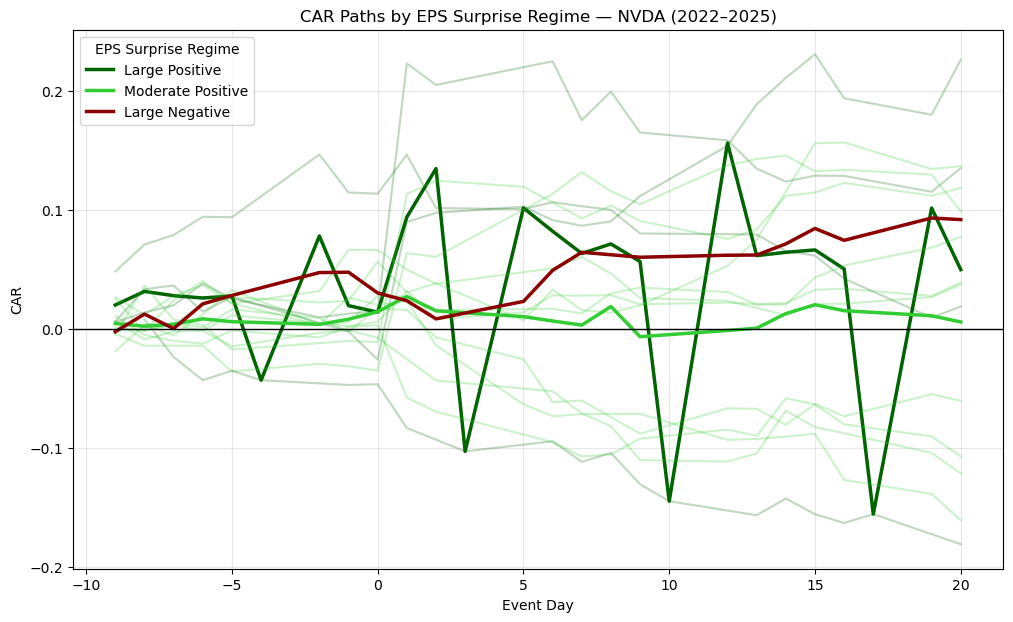

In [123]:
import matplotlib.pyplot as plt

# ============================================================
# Define the EPS regimes in the order you want them plotted
# ============================================================

regimes = [
    'large_positive',
    'moderate_positive',
    'small_positive',
    'small_negative',
    'moderate_negative',
    'large_negative'
]

# Assign a color to each regime for consistency
colors = {
    'large_positive': 'darkgreen',
    'moderate_positive': 'limegreen',
    'small_positive': 'lightgreen',
    'small_negative': 'salmon',
    'moderate_negative': 'red',
    'large_negative': 'darkred'
}

# ============================================================
# Function: One chart per company with all regimes
# ============================================================

def plot_company_all_regimes(df, ticker):
    plt.figure(figsize=(12, 7))

    for regime in regimes:
        subset = df[(df['ticker'] == ticker) & (df['eps_surprise_regime'] == regime)]
        
        if subset.empty:
            continue
        
        # Plot each event path faintly
        for event_id, grp in subset.groupby('event_id'):
            plt.plot(grp['event_day'], grp['CAR'], 
                     color=colors[regime], alpha=0.25)
        
        # Plot the average CAR path for this regime
        avg_path = subset.groupby('event_day')['CAR'].mean()
        plt.plot(avg_path.index, avg_path.values, 
                 color=colors[regime], linewidth=2.5, 
                 label=regime.replace('_', ' ').title())

    plt.axhline(0, color='black', linewidth=1)
    plt.title(f"CAR Paths by EPS Surprise Regime — {ticker} (2022–2025)")
    plt.xlabel("Event Day")
    plt.ylabel("CAR")
    plt.legend(title="EPS Surprise Regime")
    plt.grid(alpha=0.3)
    plt.show()

# ============================================================
# Generate one chart per company
# ============================================================

plot_company_all_regimes(panel_sub, 'AAPL')
plot_company_all_regimes(panel_sub, 'GOOGL')
plot_company_all_regimes(panel_sub, 'NVDA')

In [124]:
fund.columns.tolist()

['fiscalDateEnding',
 'reportedDate',
 'reportedEPS',
 'estimatedEPS',
 'surprise',
 'surprisePercentage',
 'reportTime',
 'symbol',
 'totalRevenue',
 'grossProfit',
 'operatingIncome',
 'netIncome',
 'grossMargin',
 'operatingMargin',
 'netMargin',
 'event_id',
 'ticker',
 'revenue_growth',
 'margin_trend',
 'profitability',
 'revenue_growth_regime',
 'eps_surprise_regime',
 'profitability_regime',
 'margin_trend_regime',
 'financial_strength_regime']

In [126]:
panel = car_panel.merge(
    fund[['event_id','ticker','reportedDate',
          'eps_surprise_regime',
          'profitability_regime',
          'margin_trend_regime',
          'financial_strength_regime',
          'revenue_growth_regime']],   # ← ADD THIS
    left_on='event_id_corrected',
    right_on='event_id',
    how='left'
)

KeyError: 'event_id_corrected'

In [127]:
car_panel.columns.tolist()

['event_id', 'ticker', 'date', 'event_day', 'abnormal_return']

In [128]:
panel = car_panel.merge(
    fund[['event_id',
          'ticker',
          'reportedDate',
          'eps_surprise_regime',
          'profitability_regime',
          'margin_trend_regime',
          'financial_strength_regime',
          'revenue_growth_regime']],
    on='event_id',
    how='left'
)

In [129]:
panel = panel.rename(columns={'ticker_y': 'ticker'})
panel = panel.drop(columns=['ticker_x'], errors='ignore')

In [130]:
panel['reportedDate'] = pd.to_datetime(panel['reportedDate'])

panel_sub = panel[
    (panel['reportedDate'] >= '2022-01-01') &
    (panel['reportedDate'] <= '2025-12-31')
].copy()

In [132]:
fund['event_id'].head()
car_panel['event_id'].head()
set(fund['event_id']).intersection(set(car_panel['event_id']))

set()

In [133]:
fund['event_id'].head(10).tolist()

['AAPL_2005-09-30',
 'AAPL_2005-12-31',
 'AAPL_2006-03-31',
 'AAPL_2006-06-30',
 'AAPL_2006-09-30',
 'AAPL_2006-12-31',
 'AAPL_2007-03-31',
 'AAPL_2007-06-30',
 'AAPL_2007-09-30',
 'AAPL_2007-12-31']

In [134]:
car_panel['event_id'].head(10).tolist()

['AAPL_2005-07-13',
 'AAPL_2005-07-13',
 'AAPL_2005-07-13',
 'AAPL_2005-07-13',
 'AAPL_2005-07-13',
 'AAPL_2005-07-13',
 'AAPL_2005-07-13',
 'AAPL_2005-07-13',
 'AAPL_2005-07-13',
 'AAPL_2005-07-13']

In [135]:
fund['event_id_announcement'] = (
    fund['ticker'] + '_' + fund['reportedDate'].dt.strftime('%Y-%m-%d')
)

In [136]:
panel = car_panel.merge(
    fund[['event_id_announcement',
          'ticker',
          'reportedDate',
          'eps_surprise_regime',
          'profitability_regime',
          'margin_trend_regime',
          'financial_strength_regime',
          'revenue_growth_regime']],
    left_on='event_id',
    right_on='event_id_announcement',
    how='left'
)

In [137]:
panel = panel.drop(columns=['event_id_announcement'])

In [138]:
panel['reportedDate'] = pd.to_datetime(panel['reportedDate'])

panel_sub = panel[
    (panel['reportedDate'] >= '2022-01-01') &
    (panel['reportedDate'] <= '2025-12-31')
].copy()

In [139]:
panel_sub['revenue_growth_regime'].unique()

array(['high_growth', 'negative_growth', 'moderate_growth'], dtype=object)

In [140]:
panel.to_csv(r"D:/LSE Career Accelerator/Employer project/Adrian's financial metrics data/merged_event_panel.csv", index=False)

In [141]:
import matplotlib.pyplot as plt

def plot_company_by_regime(df, ticker, regime_col, regime_order=None, colors=None):
    """
    df: panel_sub
    ticker: 'AAPL', 'GOOGL', 'NVDA'
    regime_col: e.g. 'profitability_regime'
    regime_order: list of regime names in desired order
    colors: dict mapping regime -> color
    """

    # If no custom order is provided, infer from data
    if regime_order is None:
        regime_order = sorted(df[regime_col].dropna().unique())

    # If no colors provided, auto-generate
    if colors is None:
        import seaborn as sns
        palette = sns.color_palette("tab10", len(regime_order))
        colors = {regime: palette[i] for i, regime in enumerate(regime_order)}

    plt.figure(figsize=(12, 7))

    for regime in regime_order:
        subset = df[(df['ticker'] == ticker) & (df[regime_col] == regime)]

        if subset.empty:
            continue

        # Plot faint individual paths
        for event_id, grp in subset.groupby('event_id'):
            plt.plot(grp['event_day'], grp['CAR'], color=colors[regime], alpha=0.25)

        # Plot bold average path
        avg_path = subset.groupby('event_day')['CAR'].mean()
        plt.plot(avg_path.index, avg_path.values,
                 color=colors[regime], linewidth=2.5,
                 label=str(regime).replace('_', ' ').title())

    plt.axhline(0, color='black', linewidth=1)
    plt.title(f"CAR Paths by {regime_col.replace('_',' ').title()} — {ticker} (2022–2025)")
    plt.xlabel("Event Day")
    plt.ylabel("CAR")
    plt.legend(title=regime_col.replace('_',' ').title())
    plt.grid(alpha=0.3)
    plt.show()

In [142]:
profit_order = ['high', 'medium', 'low']  # adjust if needed

for t in ['AAPL', 'GOOGL', 'NVDA']:
    plot_company_by_regime(panel_sub, t, 'profitability_regime', profit_order)

KeyError: 'ticker'

<Figure size 1200x700 with 0 Axes>

In [143]:
panel_sub.columns.tolist()

['event_id',
 'ticker_x',
 'date',
 'event_day',
 'abnormal_return',
 'ticker_y',
 'reportedDate',
 'eps_surprise_regime',
 'profitability_regime',
 'margin_trend_regime',
 'financial_strength_regime',
 'revenue_growth_regime']

In [144]:
panel_sub['ticker'] = panel_sub['ticker_y']

In [145]:
panel_sub = panel_sub.drop(columns=['ticker_x', 'ticker_y'], errors='ignore')

In [146]:
panel_sub.columns.tolist()

['event_id',
 'date',
 'event_day',
 'abnormal_return',
 'reportedDate',
 'eps_surprise_regime',
 'profitability_regime',
 'margin_trend_regime',
 'financial_strength_regime',
 'revenue_growth_regime',
 'ticker']

In [147]:
panel_sub.to_csv(r"D:/LSE Career Accelerator/Employer project/Adrian's financial metrics data/merged_event_panel_sub.csv", index=False)

In [148]:
import matplotlib.pyplot as plt

def plot_company_by_regime(df, ticker, regime_col, regime_order=None, colors=None):
    """
    df: panel_sub
    ticker: 'AAPL', 'GOOGL', 'NVDA'
    regime_col: e.g. 'profitability_regime'
    regime_order: list of regime names in desired order
    colors: dict mapping regime -> color
    """

    # If no custom order is provided, infer from data
    if regime_order is None:
        regime_order = sorted(df[regime_col].dropna().unique())

    # If no colors provided, auto-generate
    if colors is None:
        import seaborn as sns
        palette = sns.color_palette("tab10", len(regime_order))
        colors = {regime: palette[i] for i, regime in enumerate(regime_order)}

    plt.figure(figsize=(12, 7))

    for regime in regime_order:
        subset = df[(df['ticker'] == ticker) & (df[regime_col] == regime)]

        if subset.empty:
            continue

        # Faint individual CAR paths
        for event_id, grp in subset.groupby('event_id'):
            plt.plot(grp['event_day'], grp['abnormal_return'].cumsum(),
                     color=colors[regime], alpha=0.25)

        # Bold average CAR path
        avg_path = subset.groupby('event_day')['abnormal_return'].mean().cumsum()
        plt.plot(avg_path.index, avg_path.values,
                 color=colors[regime], linewidth=2.5,
                 label=str(regime).replace('_', ' ').title())

    plt.axhline(0, color='black', linewidth=1)
    plt.title(f"CAR Paths by {regime_col.replace('_',' ').title()} — {ticker} (2022–2025)")
    plt.xlabel("Event Day")
    plt.ylabel("CAR")
    plt.legend(title=regime_col.replace('_',' ').title())
    plt.grid(alpha=0.3)
    plt.show()

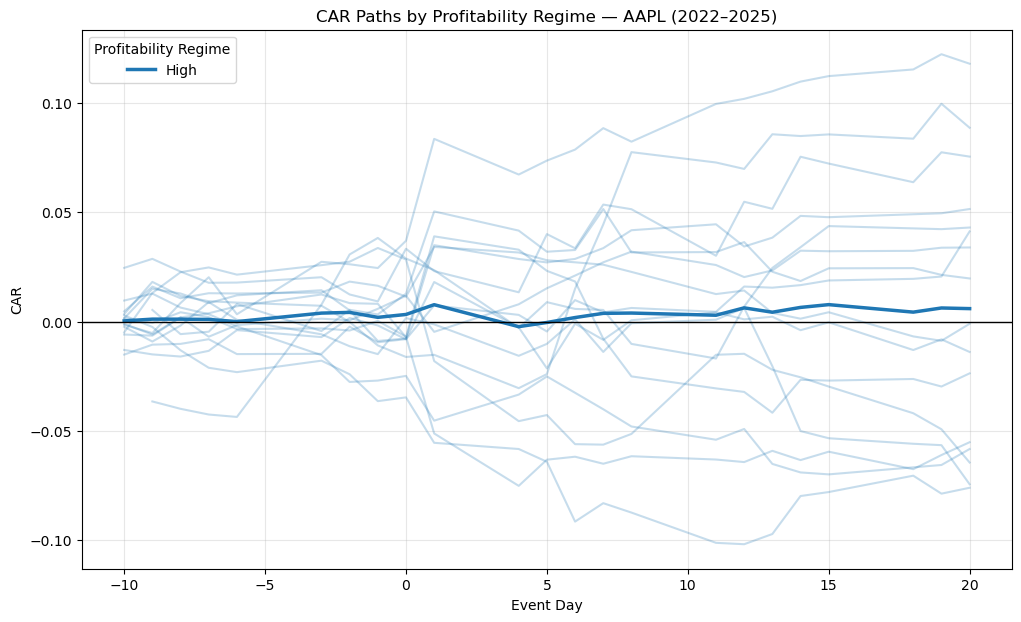

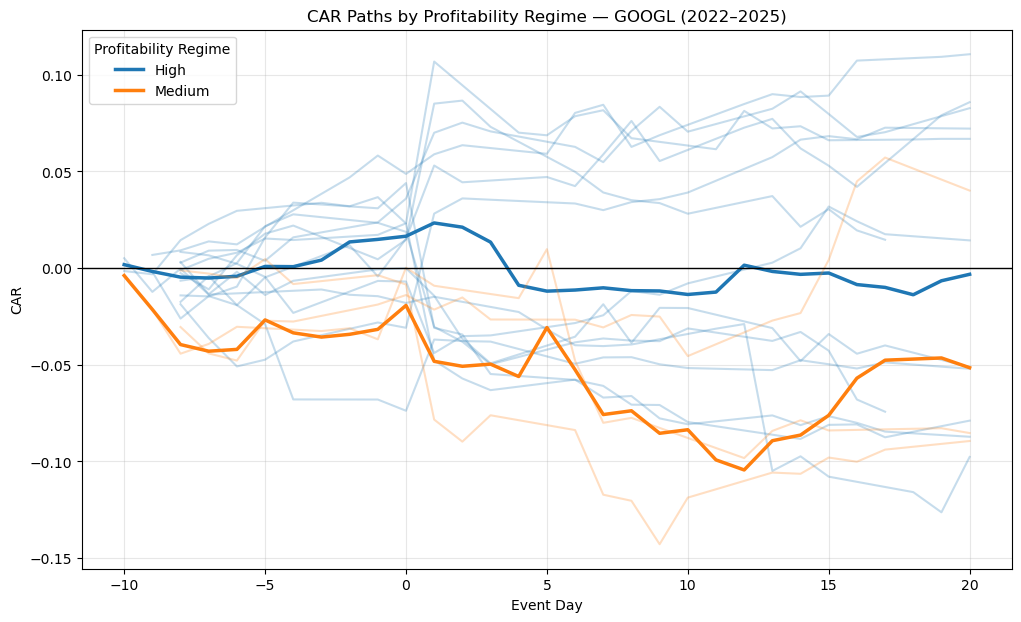

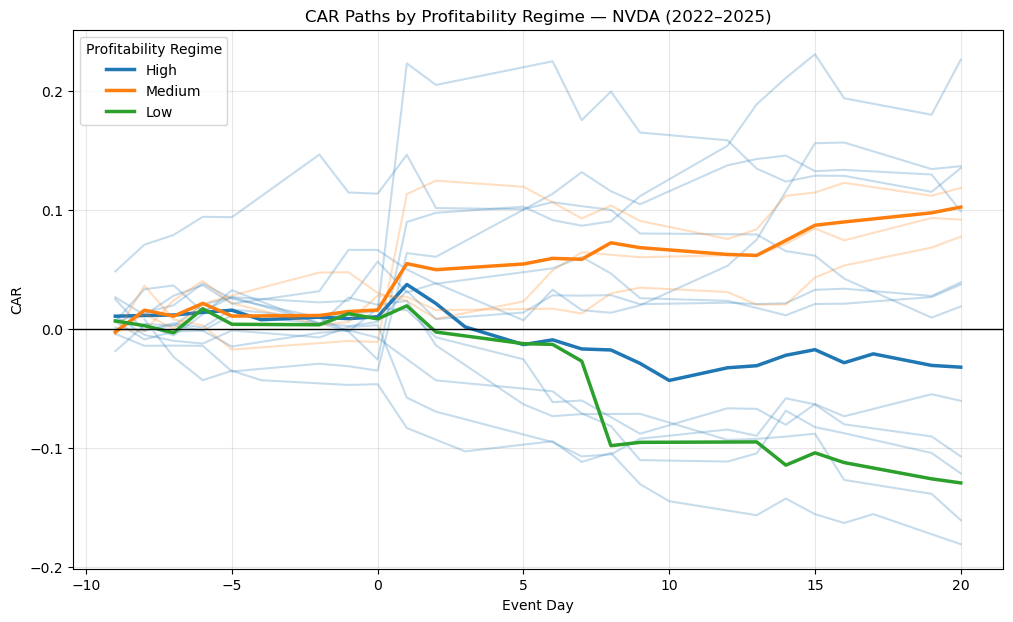

In [149]:
profit_order = ['high', 'medium', 'low']

for t in ['AAPL', 'GOOGL', 'NVDA']:
    plot_company_by_regime(panel_sub, t, 'profitability_regime', profit_order)

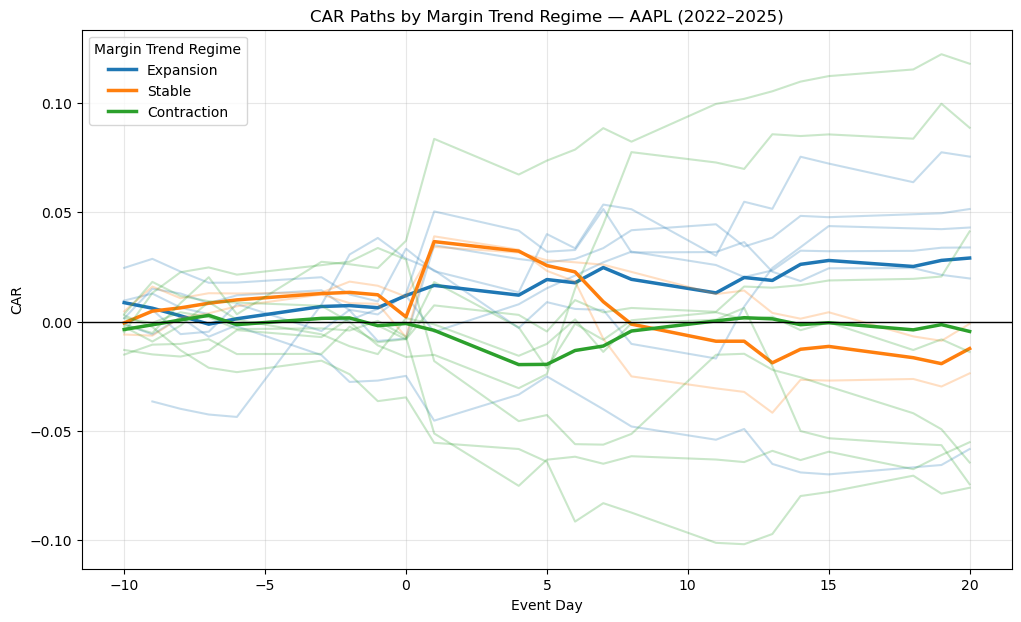

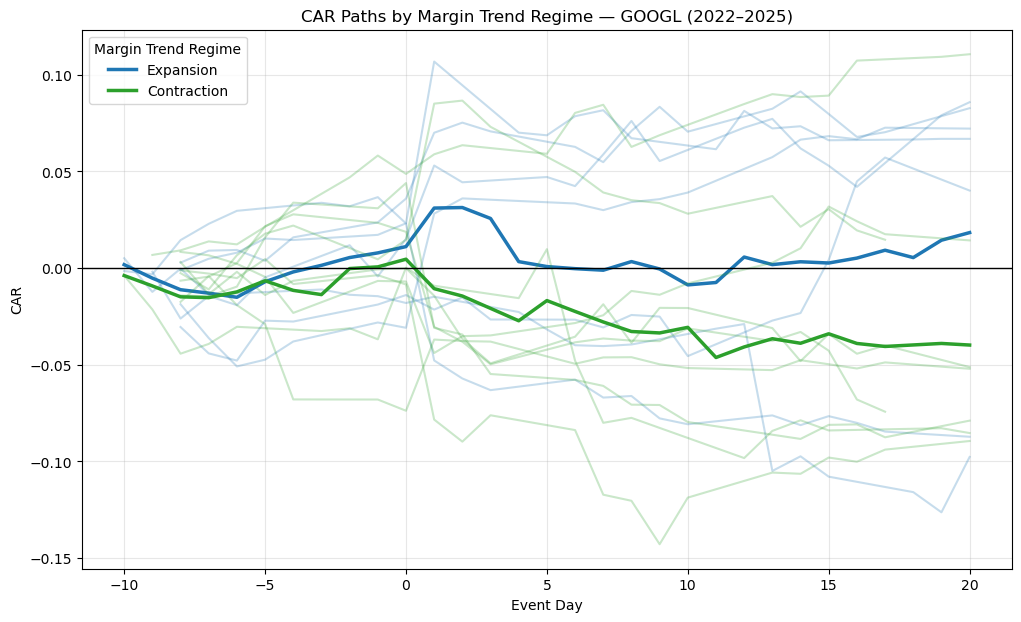

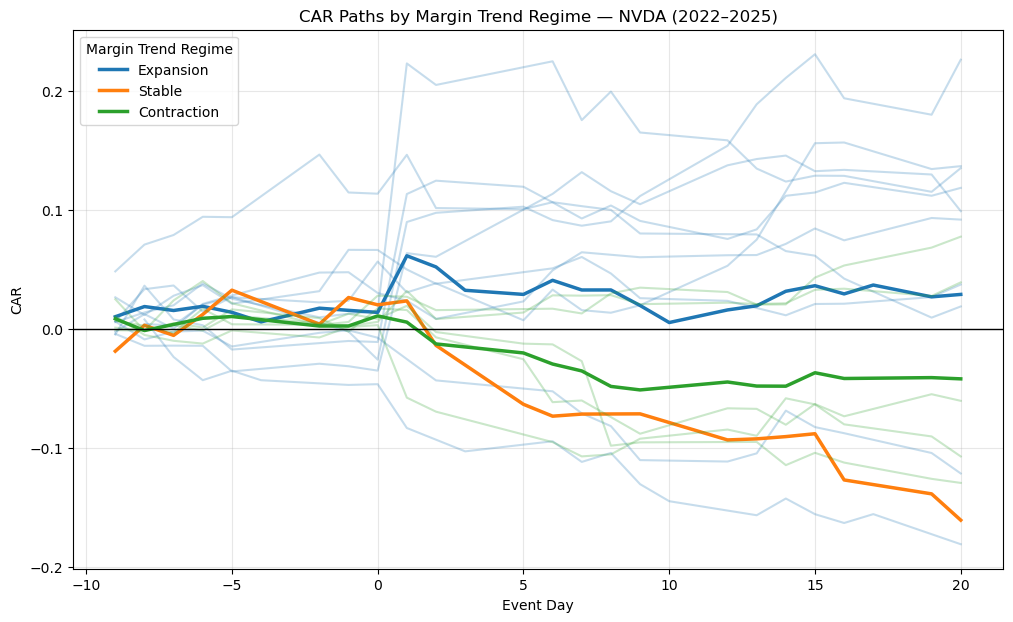

In [156]:
margin_order = ['expansion', 'stable', 'contraction']

for t in ['AAPL', 'GOOGL', 'NVDA']:
    plot_company_by_regime(panel_sub, t, 'margin_trend_regime', margin_order)

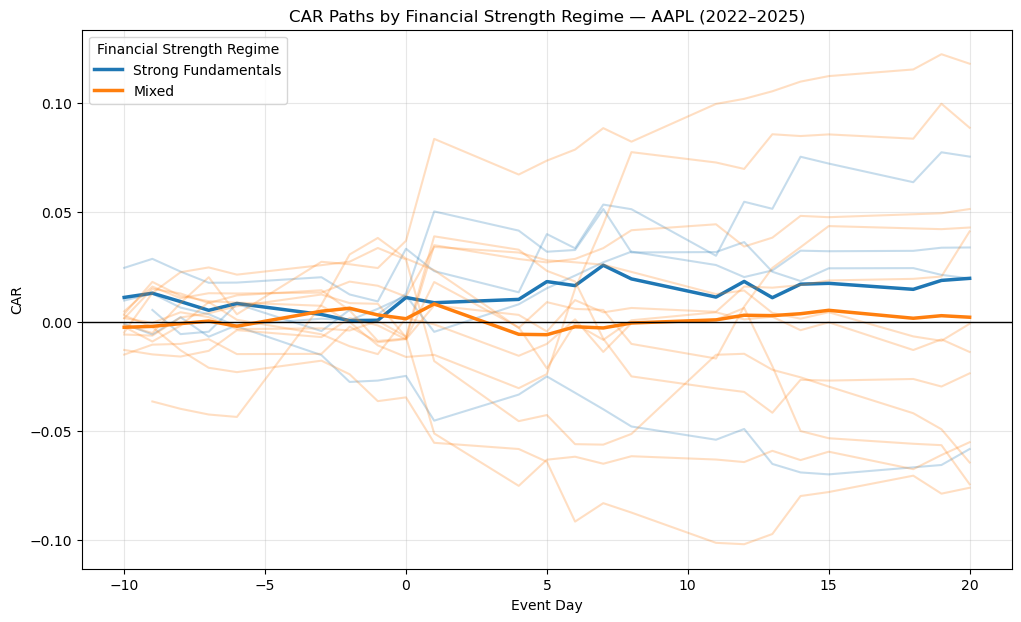

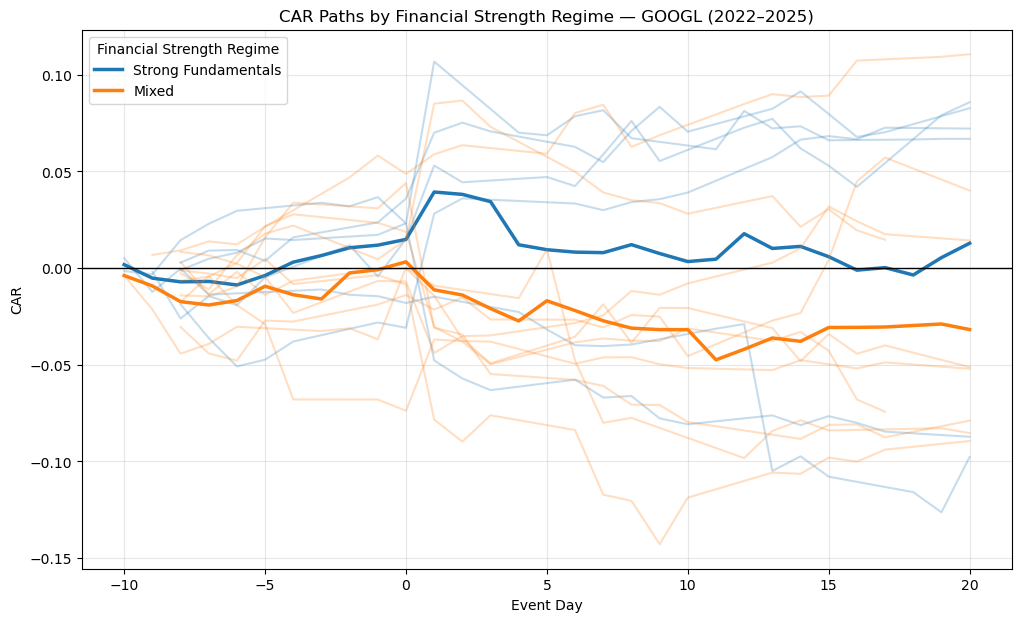

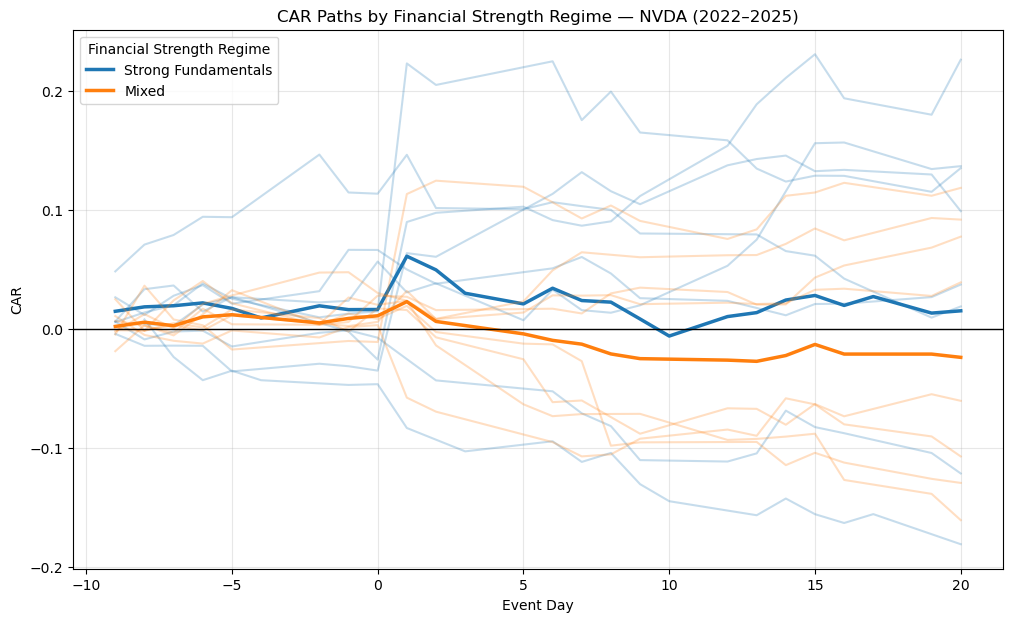

In [154]:
strength_order = ['strong_fundamentals', 'mixed']

for t in ['AAPL', 'GOOGL', 'NVDA']:
    plot_company_by_regime(panel_sub, t, 'financial_strength_regime', strength_order)

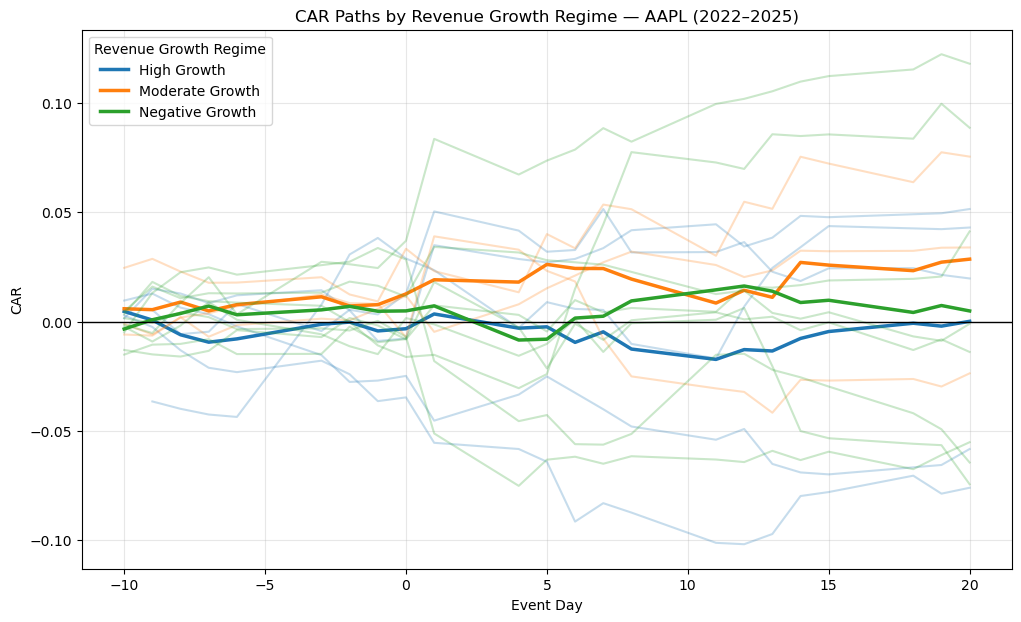

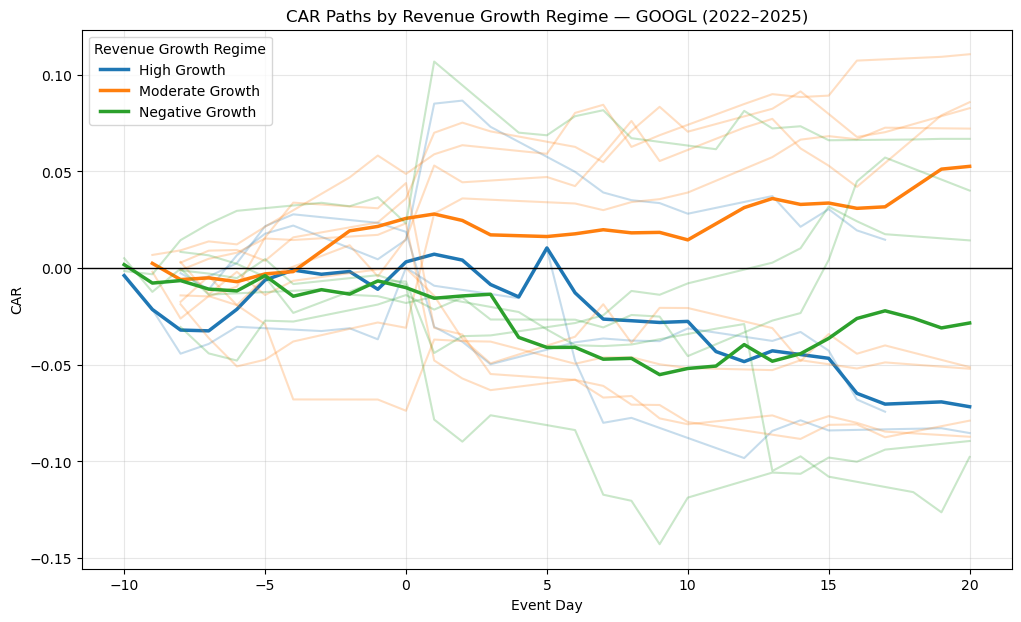

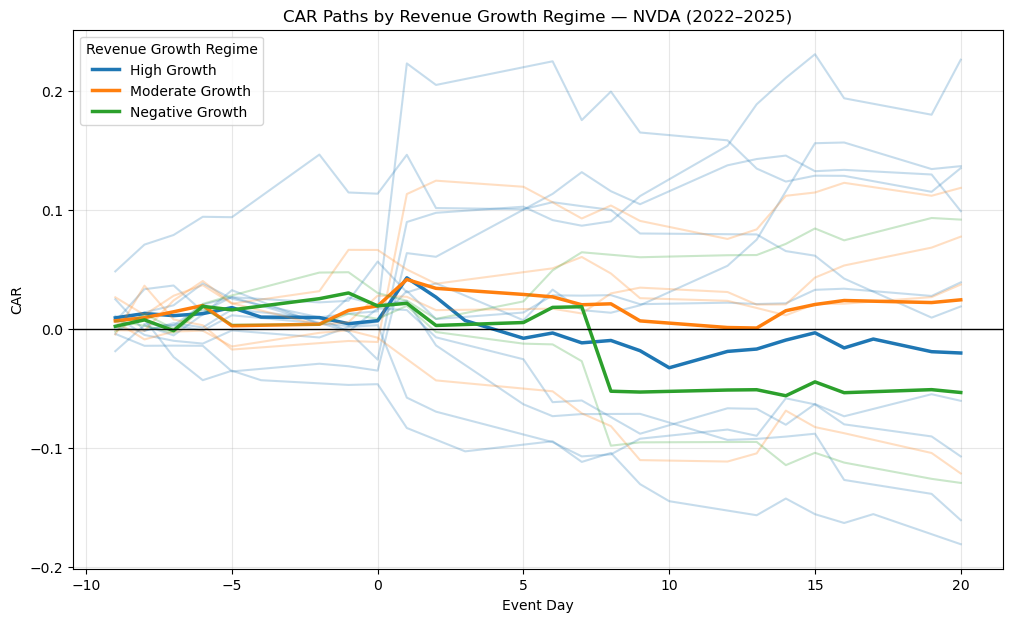

In [152]:
growth_order = ['high_growth', 'moderate_growth', 'negative_growth']

for t in ['AAPL', 'GOOGL', 'NVDA']:
    plot_company_by_regime(panel_sub, t, 'revenue_growth_regime', growth_order)

In [153]:
panel_sub['financial_strength_regime'].value_counts(dropna=False)

financial_strength_regime
mixed                  650
strong_fundamentals    387
Name: count, dtype: int64

In [155]:
panel_sub['margin_trend_regime'].value_counts(dropna=False)


margin_trend_regime
expansion      493
contraction    477
stable          67
Name: count, dtype: int64

In [157]:
panel_sub['revenue_growth_regime'].value_counts(dropna=False)

revenue_growth_regime
high_growth        381
negative_growth    334
moderate_growth    322
Name: count, dtype: int64

In [158]:
panel_sub['profitability_regime'].value_counts(dropna=False)

profitability_regime
high      889
medium    127
low        21
Name: count, dtype: int64

In [160]:
panel_sub[panel_sub['ticker'] == 'AAPL']['profitability_regime'].value_counts()

profitability_regime
high    363
Name: count, dtype: int64